In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/anhvuong/MachineLearning/.venv/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/anhvuong/MachineLearning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anhvuong/MachineLearning/.venv/lib/python3.9/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as 

In [2]:
df = pd.read_csv("/Users/anhvuong/MachineLearning/SMSSpamDetection/spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    df['Text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42
)
x_train_np = x_train.to_numpy()
x_Test_np = x_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test = y_test.to_numpy()

In [5]:
avg_words_len = round(sum([len(i.split())
                    for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(x_train_np)}")
print(f"Average words per message: {avg_words_len}")
print(f"Approximate vocabulary size: {total_words_length}")


Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


In [6]:
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics =['accuracy']
    )
    history = model.fit(
        x_train_np,
        y_train_np,
        epochs=epochs,
        validation_data=(x_Test_np, y_test),
    )
    return history

def get_metrics(model, x, y):
    y_preds = np.round(model.predict(x))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1': f1_score(y, y_preds)
    }

In [8]:
from tensorflow.keras import layers

text_vec = layers.TextVectorization(
    max_tokens = total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = avg_words_len
)
text_vec.adapt(x_train_np)

In [9]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length,
                output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name ='Dense_Model' )
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 [==============================] - 1s 3ms/step - loss: 0.3625 - accuracy: 0.8795 - val_loss: 0.1437 - val_accuracy: 0.9614
Epoch 2/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0849 - accuracy: 0.9794 - val_loss: 0.0806 - val_accuracy: 0.9776
Epoch 3/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9901 - val_loss: 0.0673 - val_accuracy: 0.9776
Epoch 4/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9960 - val_loss: 0.0658 - val_accuracy: 0.9785
Epoch 5/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9978 - val_loss: 0.0642 - val_accuracy: 0.9776


In [10]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name ='BiLSTM_Model')
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 [==============================] - 3s 10ms/step - loss: 0.1611 - accuracy: 0.9493 - val_loss: 0.0885 - val_accuracy: 0.9758
Epoch 2/5
140/140 [==============================] - 1s 8ms/step - loss: 0.0324 - accuracy: 0.9919 - val_loss: 0.0736 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 1s 8ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0981 - val_accuracy: 0.9785
Epoch 4/5
140/140 [==============================] - 1s 8ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.1074 - val_accuracy: 0.9767
Epoch 5/5
140/140 [==============================] - 1s 7ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.1136 - val_accuracy: 0.9776


In [11]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(
    x), output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(input_layer, output_layer, name="USE_Model")

history_3 = compile_and_fit(model_3)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_29:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_28:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_27:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_26:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_25:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_24:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_23:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/Ad

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_29:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_28:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_27:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_26:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_25:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_24:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_23:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/Ad

Epoch 1/5
140/140 [==============================] - 1s 3ms/step - loss: 0.2768 - accuracy: 0.9192 - val_loss: 0.1065 - val_accuracy: 0.9713
Epoch 2/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9796 - val_loss: 0.0681 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0546 - accuracy: 0.9850 - val_loss: 0.0583 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9877 - val_loss: 0.0546 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.9895 - val_loss: 0.0522 - val_accuracy: 0.9839


In [13]:
results = {
    'Dense Embedding': get_metrics(model_1, x_Test_np, y_test),
    'BiLSTM': get_metrics(model_2, x_Test_np, y_test),
    'USE': get_metrics(model_3, x_Test_np, y_test),
}
results_df = pd.DataFrame(results).transpose()
print("Performance Table:")
print(results_df)

35/35 [==============================] - 0s 3ms/step
Performance Table:
                 accuracy  precision    recall        f1
Dense Embedding  0.977578   0.949275  0.879195  0.912892
BiLSTM           0.977578   0.930556  0.899329  0.914676
USE              0.983857   0.951724  0.926174  0.938776


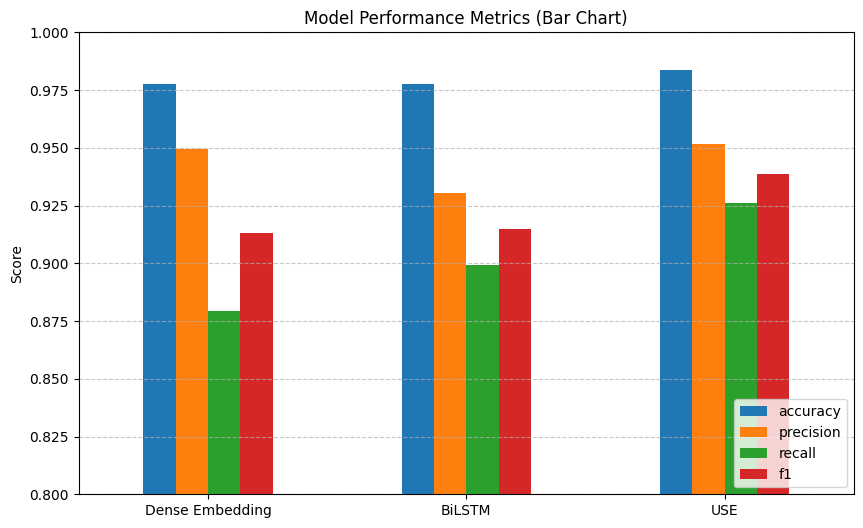

In [14]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

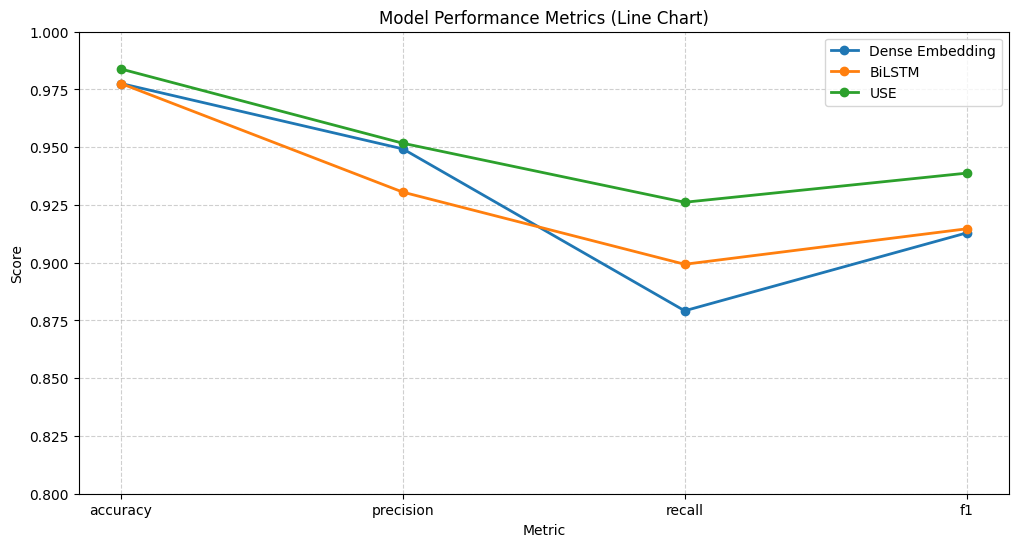

In [16]:
plt.figure(figsize=(12, 6))

for model_name in results_df.index:
    plt.plot(
        results_df.columns,
        results_df.loc[model_name],
        marker='o',
        label=model_name,
        linewidth=2
    )
    
plt.title("Model Performance Metrics (Line Chart)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.8, 1.0)
plt.grid(linestyle='--', alpha=0.6)
plt.legend()
plt.show()
